In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [11]:
engine.execute('SELECT * FROM Station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
measurement_columns = inspector.get_columns('measurement')
for m_c in measurement_columns:
    print(m_c['name'], m_c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
station_columns = inspector.get_columns('station')
for m_c in station_columns:
    print(m_c['name'], m_c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

Measurement = Base.classes.measurement
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from today
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
Precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).\
            order_by(Measurement.date.desc()).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(Precipitation[:], columns=['date', 'prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_index()
df.head()

,prcp
date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,NaN


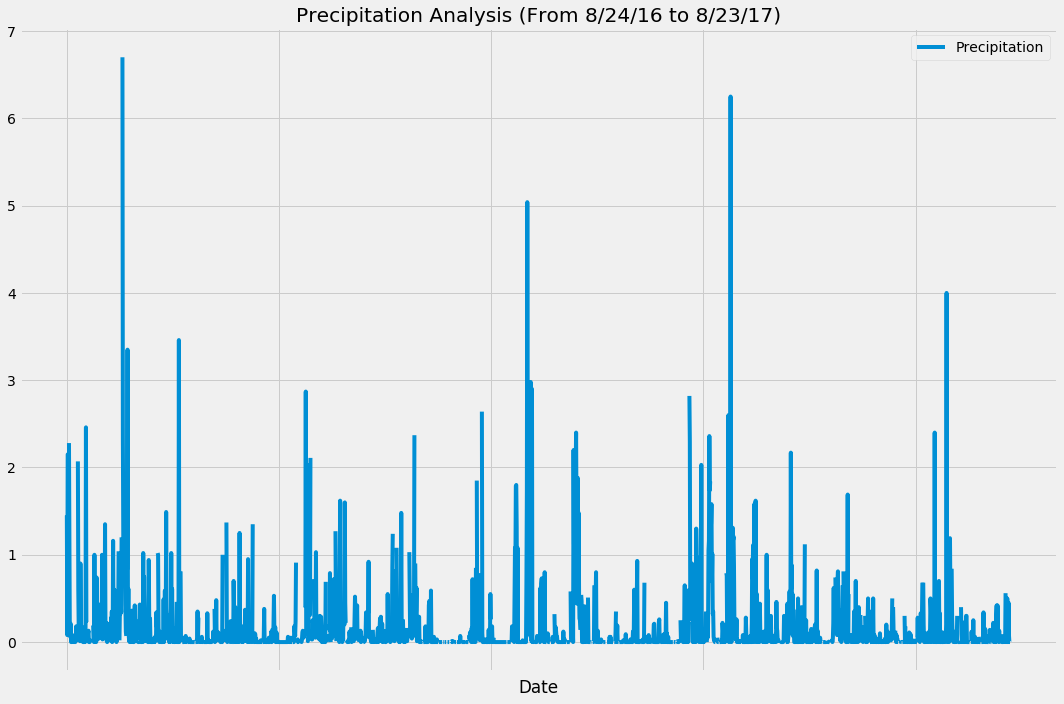

In [79]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="line",linewidth=4,figsize=(15,10))
plt.style.use('fivethirtyeight')
plt.xlabel("Date")
plt.title("Precipitation Analysis (From 8/24/16 to 8/23/17)")

# Rotate the xticks for the dates

plt.xticks(rotation=45)
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# How many stations are available in this dataset?

stations_count = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(stations_count))

There are 9 stations.


In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station = 'USC00519281';

active_station_stat = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

active_station_stat

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [22]:
# A query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519397').\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

temperature

[('USC00519397', '2016-08-24', 79.0),
 ('USC00519397', '2016-08-25', 80.0),
 ('USC00519397', '2016-08-26', 79.0),
 ('USC00519397', '2016-08-27', 77.0),
 ('USC00519397', '2016-08-28', 78.0),
 ('USC00519397', '2016-08-29', 78.0),
 ('USC00519397', '2016-08-30', 79.0),
 ('USC00519397', '2016-08-31', 80.0),
 ('USC00519397', '2016-09-01', 81.0),
 ('USC00519397', '2016-09-02', 80.0),
 ('USC00519397', '2016-09-03', 79.0),
 ('USC00519397', '2016-09-04', 75.0),
 ('USC00519397', '2016-09-05', 79.0),
 ('USC00519397', '2016-09-06', 76.0),
 ('USC00519397', '2016-09-07', 76.0),
 ('USC00519397', '2016-09-08', 80.0),
 ('USC00519397', '2016-09-09', 79.0),
 ('USC00519397', '2016-09-10', 78.0),
 ('USC00519397', '2016-09-11', 76.0),
 ('USC00519397', '2016-09-12', 78.0),
 ('USC00519397', '2016-09-13', 78.0),
 ('USC00519397', '2016-09-14', 75.0),
 ('USC00519397', '2016-09-15', 79.0),
 ('USC00519397', '2016-09-16', 80.0),
 ('USC00519397', '2016-09-17', 79.0),
 ('USC00519397', '2016-09-18', 81.0),
 ('USC005193

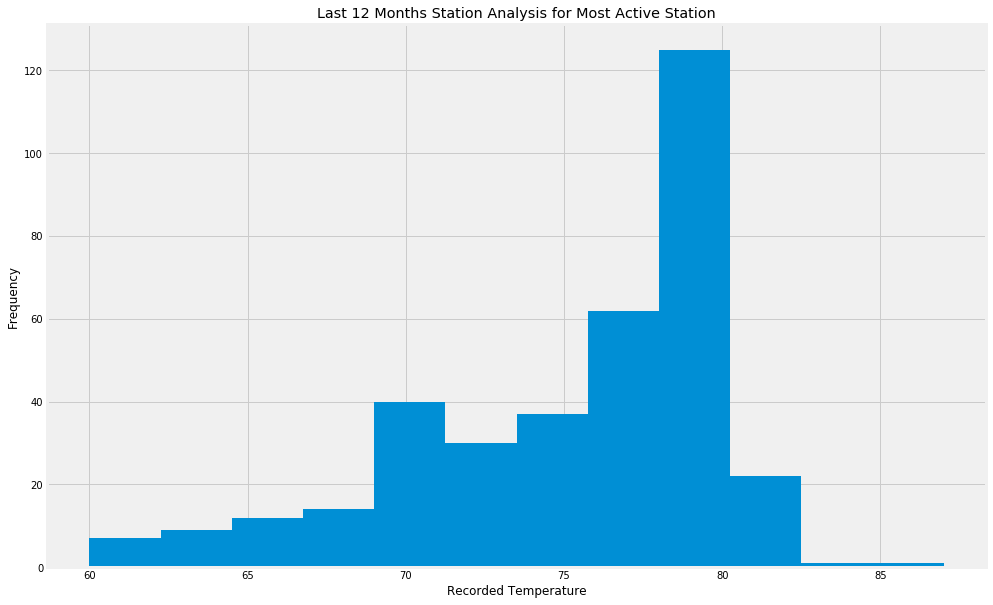

In [23]:
# Plot the results as a histogram with bins=12.

measure_df=pd.DataFrame(temperature)
hist_plot = measure_df['tobs'].hist(bins=12, figsize=(15,10))
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Last 12 Months Station Analysis for Most Active Station")
plt.show()

In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_departure = dt.date(2018, 5, 1)
trip_arrival = dt.date(2018, 4, 2)
last_year = dt.timedelta(days=365)

trip_stat = (calc_temps((trip_arrival - last_year), (trip_departure - last_year)))
print(trip_stat)

[(58.0, 73.5421052631579, 83.0)]


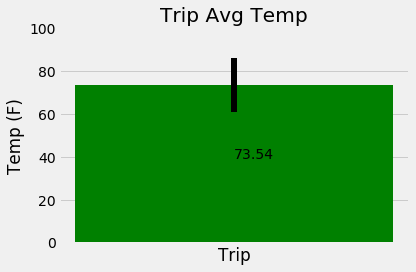

In [90]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

average_temp = trip_stat[0][1]
minimum_temp = trip_stat[0][0]
maximum_temp = trip_stat[0][2]
peak_yerr = (maximum_temp - minimum_temp)/2

barvalue = [average_temp]
xvals = range(len(barvalue))

fig, ax = plt.subplots()
rects = ax.bar(xvals, barvalue, width, color='g', yerr=peak_yerr,
              error_kw=dict(elinewidth=6, ecolor='black'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., .6*height, '%.2f'%float(height),
                ha='left', va='top')

autolabel(rects)

plt.ylim(0, 100)
ax.set_xticks([1]) 
ax.set_xlabel("Trip")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")
fig.tight_layout()
plt.show()

In [91]:
#trip dates - last year
trip_arrival_date = trip_arrival - last_year
trip_departure_date = trip_departure - last_year

print(trip_arrival_date)
print(trip_departure_date)

2017-04-02
2017-05-01


In [92]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_arrival_date = trip_arrival - last_year
trip_departure_date = trip_departure - last_year

rainfall_trip_data = session.query(Measurement.station, Measurement.date, func.avg(Measurement.prcp), Measurement.tobs).\
                filter(Measurement.date >= trip_arrival_date).\
                filter(Measurement.date <= trip_departure_date).\
                group_by(Measurement.station).\
                order_by(Measurement.prcp.desc()).all()

rainfall_trip_data

[('USC00519397', '2017-05-01', 0.07366666666666667, 75.0),
 ('USC00516128', '2017-05-01', 0.4942857142857144, 73.0),
 ('USC00519281', '2017-05-01', 0.44799999999999984, 65.0),
 ('USC00513117', '2017-05-01', 0.3163333333333333, 68.0),
 ('USC00519523', '2017-05-01', 0.4464, 73.0),
 ('USC00514830', '2017-05-01', 0.2247826086956522, 78.0),
 ('USC00517948', '2017-04-28', 0.0, 76.0)]

In [93]:
df_rainfall_stations = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                order_by(Station.station.desc()).all()
df_rainfall_stations

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)]

In [94]:
df_rainfall = pd.DataFrame(rainfall_trip_data[:], columns=['station','date','precipitation','temperature'])
df_station = pd.DataFrame(df_rainfall_stations[:], columns=['station', 'name', 'latitude', 'longitude', 'elevation'])
df_station

,station,name,latitude,longitude,elevation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


In [95]:
result = pd.merge(df_rainfall, df_station, on='station')
df_result = result.drop(['date','precipitation','temperature',], 1)
df_result

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [73]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [96]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
